In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <span style="color:black">**Regression Modelling of Life Expectancy - Noah Rubin**</span>

---

<ins>Project Overview:</ins>

In this personal project I look into ways of modelling life expectancy using a variety of regression models, including:
* Ordinary Least Squares Regression
* Ridge Regression
* LASSO Regression
* Elastic Net Regression
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting
* Adaptive Boosting
* Catboost Regression
* Extreme Gradient Boosting (XGBoost)

---

The variables in my original dataset include:
* **Country**
* **Year**
* **InfantMortality:** The number of infants dying before the age of one, per 1000 live births
* **Health_exp:** The percentage of their total GDP that a country has spent on health
* **Life_exp:** Life expectancy at birth (this was the dependent variable for all the models I built)
* **GDP_cap:** Per capita income in $USD
* **Employment:** Employment to population ratio for people over the age of 15.
* **Status:** Whether they are a developed or a developing country
* **MeanSchooling:** Average number of completed years of education for those aged 25 years and older
* **ElectricityAccess:** The percentage of the population who have access to electricity

---

This first notebook will predominantly consist of basic cleaning and some visualisations.

In [44]:
# My modules
import data_cleaning as dc
import basic_visuals as bv

import numpy as np
import pandas as pd
import pandas_bokeh as pdbk
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.models import Legend

from scipy import stats
from sklearn.model_selection import train_test_split

# Display settings
plt.style.use('seaborn-whitegrid') 
%config InlineBackend.figure_format = 'svg'  
pdbk.output_notebook()

Loading BokehJS ...

In [4]:
# Load in the data
possible_nans = ['na', 'Na', 'NA', 'null', 'Null', 'NULL', 'missing', 
                 'Nan', 'NAN', 'Nan', 'NAN', 'Absent', '.', '..', '...', 
                 'Missing', 'MISSING', 'Missing Value', '-999999', '']

df = pd.read_csv('../data/OriginalDataset.csv', na_values=possible_nans)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            2793 non-null   object 
 1   Year               2793 non-null   int64  
 2   InfantMortality    2793 non-null   float64
 3   Health_exp         2754 non-null   float64
 4   Life_exp           2793 non-null   float64
 5   GDP_cap            2769 non-null   float64
 6   Employment         2736 non-null   float64
 7   Status             2793 non-null   object 
 8   MeanSchooling      2746 non-null   float64
 9   ElectricityAccess  2705 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 218.3+ KB
None


Country  Year  InfantMortality  Health_exp  Life_exp  \
0           Afghanistan  2000             90.2         NaN    55.841   
1                Angola  2000            121.2    1.908599    46.522   
2               Albania  2000             24.1    7.233370    73.955   
3  United Arab Emirates  2000              9.6    2.374135    74.327   
4             Argentina  2000             17.5    8.466964    73.576   

        GDP_cap  Employment      Status  MeanSchooling  ElectricityAccess  
0           NaN   42.189999  Developing            2.2                NaN  
1    556.836318   74.540001  Developing            4.4                NaN  
2   1126.683318   52.090000  Developing            8.8         100.000000  
3  33291.419366   74.250000   Developed            8.3         100.000000  
4   7708.100996   52.580002  Developing            9.1          95.445366

In [5]:
# Display missing data
dc.display_missing_data(df, (10, 6));

#### <span style="color:black">**<u>Initial Data Cleaning**</u></span>
* Lower the chances of us being misguided into making incorrect decisions
* Data that has not been cleaned will likely produce meaningless output that does not represent the real situation we are trying to model
* Distance based algorithms in general are very sensitive to outliers

#### <span style="color:black"><u>**Cleaning**</u></span>

Some strategies:

a) Handling <u>inconsistent data</u>: Removing whitespace, fixing case issues, handling blank strings. It ensures that 'Australia' and '  austrAlia   ' are treated the same

b) Handling <u>unessessary</u> data: Check for duplicated rows, or duplicates of subsets of particular rows

---

Any additional cleaning will be influenced by what I see from the training data (without looking at the test set) to avoid [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). Here I will get started with some data analysis where I intend to:

a) Explore and visualise <u>missing</u> data

d) Do some basic (mostly non-statistical) data analysis 

e) Move into the more statistics heavy Exploratory Data Analysis and data imputation **(next notebook)**



#### <span style="color:black">**a) Removing whitespace, fixing case issues, handling blank strings**</span>

In [6]:
# Uncomment the line below and comment the ones below that
# ?dc.process_inconsistent_data

df = dc.process_inconsistent_data(df)
df

Country  Year  InfantMortality  Health_exp   Life_exp  \
0              Afghanistan  2000             90.2         NaN  55.841000   
1                   Angola  2000            121.2    1.908599  46.522000   
2                  Albania  2000             24.1    7.233370  73.955000   
3     United Arab Emirates  2000              9.6    2.374135  74.327000   
4                Argentina  2000             17.5    8.466964  73.576000   
...                    ...   ...              ...         ...        ...   
2788         United States  2018              5.6   16.885298  78.539024   
2789            Uzbekistan  2018             16.5    5.291491  71.573000   
2790               Vanuatu  2018             22.4    3.373726  70.323000   
2791                 Samoa  2018             13.3    5.212627  73.187000   
2792                Zambia  2018             43.4    4.934843  63.510000   

           GDP_cap  Employment      Status  MeanSchooling  ElectricityAccess  
0              NaN   42.189999  Developing            2.2                NaN  
1       556.836318   74.540001  Developing            4.4                NaN  
2      1126.683318   52.090000  Developing            8.8         100.000000  
3     33291.419366   74.250000   Developed            8.3         100.000000  
4      7708.100996   52.580002  Developing            9.1          95.445366  
...            ...         ...         ...            ...                ...  
2788  62996.471285   59.889999   Developed           13.4         100.000000  
2789   1529.082864   58.389999  Developing           11.8         100.000000  
2790   3125.257989   68.739998  Developing            6.8          61.772453  
2791   4188.528346   40.349998  Developing           10.6          99.993614  
2792   1516.390661   65.699997  Developing            7.1          39.822304  

[2793 rows x 10 columns]

In [7]:
# Check country names to see that there is no 'Aus' or 'Austr' instead of 'Australia' etc. 
df.Country.unique()

array(['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Belarus', 'Belize', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon', 'Colombia',
       'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Cyprus', 'Germany',
       'Djibouti', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador',
       'Eritrea', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji',
       'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Equatorial Guinea', 'Greece', 'Grenada',
       'Guatemala', 'Guyana', 'Honduras', 'Croatia', 'Haiti', 'Hungary',
       'Indonesia', 'India', 'Ireland', 'Iraq', 'Iceland', 'Israel',
       'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya',
       'Cambod

#### <span style="color:black">**b) Check for duplicated rows, or duplicates of subsets of particular rows**</span>

In [8]:
# There are no complete copies of particular rows
df.duplicated().sum() == 0

True

In [10]:
# But what if a subset is duplicated (e.g. repeated Country & Year)
df[df.duplicated(subset=['Country', 'Year'])].shape[0] == 0  # No duplicated data

True

## <span style="color:black">**<u>Exploratory Data Analysis</u>**</span>

- [Exploratory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15) (EDA) through statistical techniques and visualisation methods can help summarise relationships and patterns in our dataset. 
- We can perform univariate analysis, bivariate analysis and multivariate analysis, all of which can help us in areas such as outlier detection and feature selection
- For this notebook we will just be doing very surface level EDA

The EDA I will be doing:

a) Exploring and visualising missing data

b) Surface level data analysis.

c) Outlier detection on a univariate, bivariate and multivariate level. **This stats focused part will be in the next notebook**

---
Probably going to need to do some extra cleaning as I find out more things about thedataset.

#### <span style="color:black">**a) Basic Data Analysis**</span>
- Answering questions through the use of plots

#### <span style="color:black"><u>Categorical Variables</u></span>

- A **nominal** categorical variable is a variable where order is not important e.g. Male/Female, Red/Blue/Green, Yes/No or something such as different country names
- **Ordinal** categorical data on the other hand is where there is a particular order to it (as the name suggests) e.g. (Child-Adolescent-Adult), or (Bachelor's degree - Masters degree - PhD degree) or (Bad-Good-Excellent).

#### Country

In [11]:
# All countries have 19 records (2000-2018)
df['Country'].value_counts(ascending = True)  

Vanuatu       19
Morocco       19
Turkey        19
Liberia       19
Latvia        19
              ..
Tajikistan    19
Luxembourg    19
Ecuador       19
Tunisia       19
Mexico        19
Name: Country, Length: 147, dtype: int64

#### Status

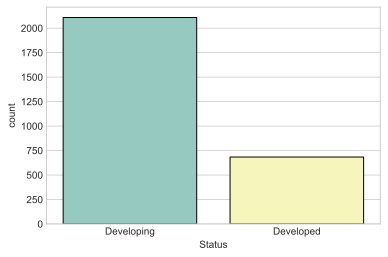

In [12]:
sns.countplot(x='Status', data = df, palette = 'Set3', edgecolor = 'black');

#### <span style="color:black"><u>Numeric Variables</u></span>

- **Discrete numeric variables** can typically be counted e.g. Shoe sizes of 6, 7, 8...
- **Continuous numeric variables** refer to variables that can be measured very precisely e.g. Heights ranging from 168.56787678cm to 193.34543453cm

### Life Expectancy Variable
--- 

#### Q: Which countries have the lowest life expectancy?

The developed world typically can expect to live for 80+ years. Lets see which nations are falling behind in this area

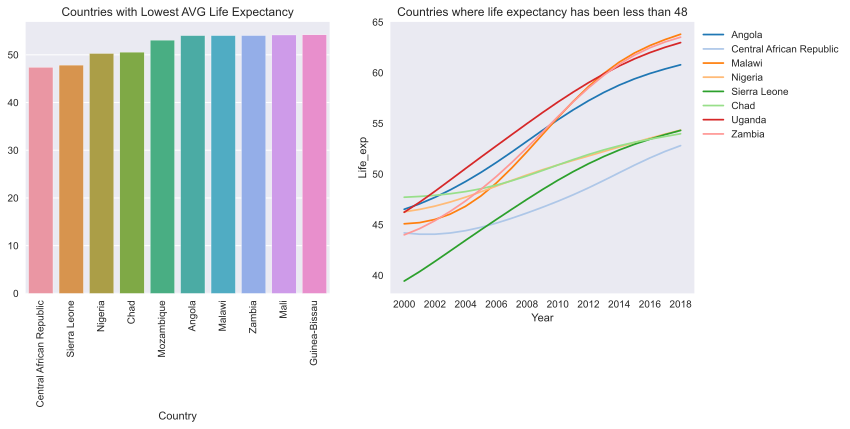

In [43]:
bv.plot_countries_low_life_exp(df, 48)

In [ ]:
# This is not the same as the countplot from before. This is plotting mean and median life expectanmcy
mean_median_grouping = df.groupby(by = 'Status')['Life_exp'].agg(['mean', 'median'])
mean_median_grouping.plot(kind = 'bar', 
                          title = 'Life Expectancy Comparison', 
                          cmap = 'Set2', 
                          edgecolor = 'black',
                          ylabel = 'Mean Life Expectancy');

One more thing I wanted to look for here is if there were any developed countries where life expectancy was lower than 60. If this is the case, it would likely be a data entry error. We'll also see if there were any develoing countries with a life expectancy greater than 75. I am confident that the latter will occur.

In [ ]:
developed_condition = ((df.Status == 'Developed') & (df['Life_exp'] <= 60))
developing_condition = ((df.Status == 'Developing') & (df['Life_exp'] >= 75))

potential_le_outliers = df.loc[developed_condition | developing_condition].copy()
potential_le_outliers.sample(10)

In [ ]:
# Check to see whether any developed countries were included in the above output
print(f"{potential_le_outliers.Status.unique()}\n")

# See all the developing countries that fulfilled the conditions in the cell above
print(potential_le_outliers.Country.unique())

Poland is considered a developed country so let's clean this up

In [ ]:
df.loc[df.Country == 'Poland', 'Status'] = 'Developed'

#### Task: Create a summary of the top and bottom five life countries for life expectancy

In [ ]:
# I will create a function for this
def graph_best_worst_countries(aggregation_variable, style = 'seaborn-whitegrid', data = df, grid1 = False, grid2 = False, palette = 'tab10'):
    
    '''
    This function will return a graph of the top and bottom 5 of a particular column (e.g. Life Expectancy) **by year**. 
    The data will be grouped by country and we can specify the <aggregation_variable> parameter that we want to do the mean 
    aggregation function on.
    '''
    
    plt.style.use(style)  
    fig, (ax1, ax2) = plt.subplots(constrained_layout = True, nrows = 2, sharex = True, figsize = (12, 10))
    fig.suptitle(f'Worst/Best Countries: {aggregation_variable}')
    # =============================================================================================================
    worst = data.groupby('Country')[aggregation_variable].mean().sort_values(ascending = True)[:5]
    df_worst = data[data.Country.isin(worst.index)]
    sns.lineplot(x = df_worst.Year, 
                 y = aggregation_variable, 
                 hue = 'Country', 
                 palette = palette,
                 data = df_worst, 
                 ax = ax1);
    ax1.legend(loc = 'best', fontsize = 'small', frameon = True)
    # =============================================================================================================
    best = data.groupby('Country')[aggregation_variable].mean().sort_values(ascending = False)[:5]
    df_best = data[data.Country.isin(best.index)]
    sns.lineplot(x = df_best['Year'], 
                 y = aggregation_variable, 
                 hue = 'Country', 
                 palette = palette,
                 data = df_best, 
                 ax = ax2);
    ax2.legend(loc = 'best', fontsize = 'small', frameon = True)

    # Display settings
    ax1.set(xlim = (df_best.Year.min() - 1, df_best.Year.max() + 1))
    ax1.ticklabel_format(useOffset = False, style = 'plain')
    
    plt.xticks(np.arange(2000, 2020, 2))
    ax2.set(xlim = (df_worst.Year.min() -1 , df_best.Year.max() + 1))
    ax2.ticklabel_format(useOffset = False, style = 'plain')
    
    ax1.grid(grid1)
    ax2.grid(grid2)

In [ ]:
# Use our function
graph_best_worst_countries(aggregation_variable = 'Life_exp')

## Infant Mortality Feature

--- 

#### Q: How does infant mortality in Australia (per 1000) compare to some other countries

In [ ]:
# Graph some mortality rates
interesting_countries = ['Australia', 'United States', 'United Kingdom',
                         'Germany', 'Finland', 'Japan', 'France',
                         'New Zealand', 'Sweden', 'Canada']

devpt_countries = df[df.Country.isin(interesting_countries)]

# Plot these countries on a line plot
fig, ax1 = plt.subplots(figsize = (10, 6))

sns.lineplot(x = 'Year', 
             y = 'InfantMortality', 
             hue = 'Country',
             palette = 'tab20',
             data = devpt_countries,
             ax = ax1)

# Adjust title, x markers and legend
ax1.set(title = 'Infant Mortality', xticks = np.arange(2000, 2020, 2))
ax1.legend(labelcolor = 'black', loc = 'best', bbox_to_anchor = [1, 1])
plt.grid(False);

#### Q: Which countries are struggling the most with high infant mortality and which countries have the lowest rates. What is the genral trend for these countries?

In [ ]:
# Reuse best/worst function from before
graph_best_worst_countries(aggregation_variable = 'InfantMortality')

In [ ]:
# The rates are lowering but the developing world is lagging far behind
df.groupby(['Year', 'Status'])['InfantMortality'].mean().plot(kind='bar', 
                                                              color='grey',
                                                              ylabel='Infant Mortality/1000',
                                                              figsize=(10, 10));

## Schooling Feature

#### Question: Which countries have had average 'MeanSchooling' less than 6 years on average (about the equivalent of finishing primary school)

In [ ]:
# Could do color=sns.color_palette("winter") but don't worry about it
plt.style.use('dark_background')

country_grouping_schooling = df[df.MeanSchooling <= 6].groupby('Country')['MeanSchooling'].mean()

country_grouping_schooling.sort_values().plot(kind = 'barh',
                                              figsize = (10, 10),
                                              xlabel = 'Mean Schooling',
                                              color = '#9933ff',
                                              grid = False,
                                              title = 'Average Years of Schooling by Country (Under 6 Years Only)',
                                              xlim = (0, 6.5));

## GDP Per Capita Feature
---
#### Q: Which countries are struggling the most economically? Which countries are the most well off?

In [ ]:
# Reuse my function
graph_best_worst_countries(aggregation_variable = 'GDP_cap', style = 'dark_background')

#### Q: Which countries have experienced the highest percentage growth in per capita income  since 2000?

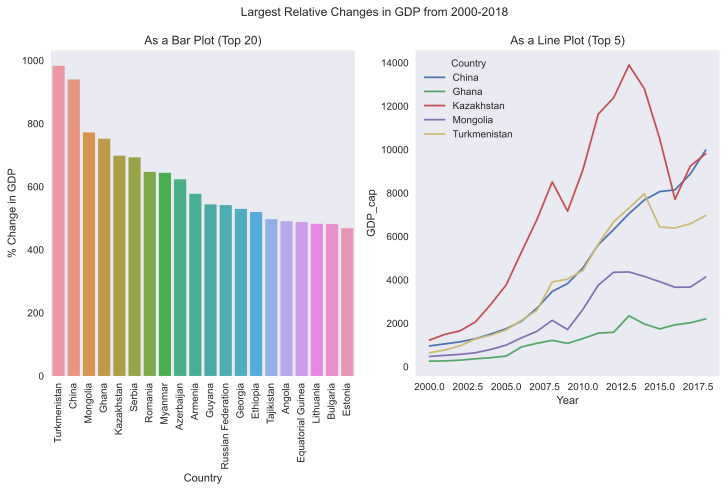

In [35]:
plt.style.use('seaborn')

records = []
for country in df.Country.unique():
    initial = df.loc[(df.Country == country) & (df.Year == df.Year.min()), 'GDP_cap'].values[0]
    final = df.loc[(df.Country == country) & (df.Year == df.Year.max()), 'GDP_cap'].values[0]
    pct_change = ((final-initial) / initial) * 100
    records.append((country, pct_change))    

# Now place all of the results in a dataframe
pct_growth = pd.DataFrame(records, columns = ['Country', '% Change in GDP'])

# Sort values by gdp change
pct_growth.sort_values(by = '% Change in GDP', 
                       ascending = False,
                       inplace = True)

# Display our data in two different ways by creating a figure with two axes
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
fig.suptitle(f'Largest Relative Changes in GDP from {df.Year.min()}-{df.Year.max()}')

# ax1 display settings
ax1.set(title = 'As a Bar Plot (Top 20)')
ax1.grid(False)
ax2.set(title = 'As a Line Plot (Top 5)')
ax2.grid(False)

# Plot for ax1
sns.barplot(x = pct_growth.Country[:20], 
            y = pct_growth['% Change in GDP'][:20],
            ax=ax1)

# Plot for ax2
sns.lineplot(data=df[df.Country.isin(pct_growth.Country[:5])], 
             x='Year',
             y='GDP_cap',
             hue='Country',
             ax=ax2);

# Rotate x ticks
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);

## Health Expenditure Feature
---
#### Q: How have attitudes towards health changed over the years

In [ ]:
# We see that the world has started to prioritise health expenditure
# Perhaps governments believe that allocating more to health will ultimately improve the overall GDP
# ...due to increased workforce productivity from a healthier overall population living longer
# Beliow is how % of gdp spent on health has changed over time

df.groupby('Year')['Health_exp'].mean().plot_bokeh(kind='line',
                                                   title='Health Expentiture Trend: (All Countries)',
                                                   color='red',
                                                   panning=False,
                                                   rangetool=True,
                                                   zooming=False,
                                                   ylabel='% of Total Expenditure');

legend = Legend(location=(30, 100))

In [ ]:
# Reuse function again to see relative smallest/biggest spenders on health expentiture
graph_best_worst_countries('Health_exp')

> Summary...

In [ ]:
# Create separate datasets for developed and developing counbtries
developed = df[df.Status == 'Developed'].copy()
developing = df[df.Status == 'Developing'].copy()

# Loop through all the numeric varibles, plotting on the y with year as the x variable
for column in df.select_dtypes(include = np.number).columns[1:]:
    fig, ax = plt.subplots()

    # Developed Countries
    developed.groupby('Year')[column].mean().plot(kind='line',
                                                  color='#cc00ff',
                                                  label='Developed',
                                                  ax=ax)
    # Developing Countries
    developing.groupby('Year')[column].mean().plot(kind='line',
                                                   color='#6699ff',
                                                   label='Developing',
                                                   ax=ax)
    
    plt.title(f"Mean {column}: Developed vs Developing")
    plt.ylabel(column)
    plt.grid(False)
    plt.legend();

# Split Data into Train/Test & Save to CSV

Save the training and test dataset in separate csv files. Putting the testing set away for a bit until I evaluate my final model on it to see how well a model performs on unseen data.

In [ ]:
train, test = train_test_split(df, train_size = 0.75, random_state = 10)

In [ ]:
train.to_csv('./data/training.csv', index = False)
test.to_csv('./data/testing.csv', index = False)